The essence of machine learning and deep learning is to take some data from the past, build an algorithm (like a neural network) to discover patterns in it and use the discovered patterns to predict the future.

**Standard WorkFlow**




*  Preparing Data
*  Building Model (From stract or Pre-trained)
*  Training Model
*  Evluate Model
*  Save trained Model



![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png)

In this notebook will use the workflow to predict a simple straight

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
torch.__version__

'2.9.0+cpu'

#### **Data (Loading and Preparing**

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [ ]:
weight = 0.7
bias = 0.3

X = torch.arange(start=0, end=1, step=0.02).unsqueeze(dim=1)
y = weight * X + bias

print(X.shape, y.shape)
print(X.ndim, y.ndim)

torch.Size([50, 1]) torch.Size([50, 1])
2 2


In [ ]:
print(X[:5])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])


In [ ]:
# 80% of data used for training set, 20% for testing

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

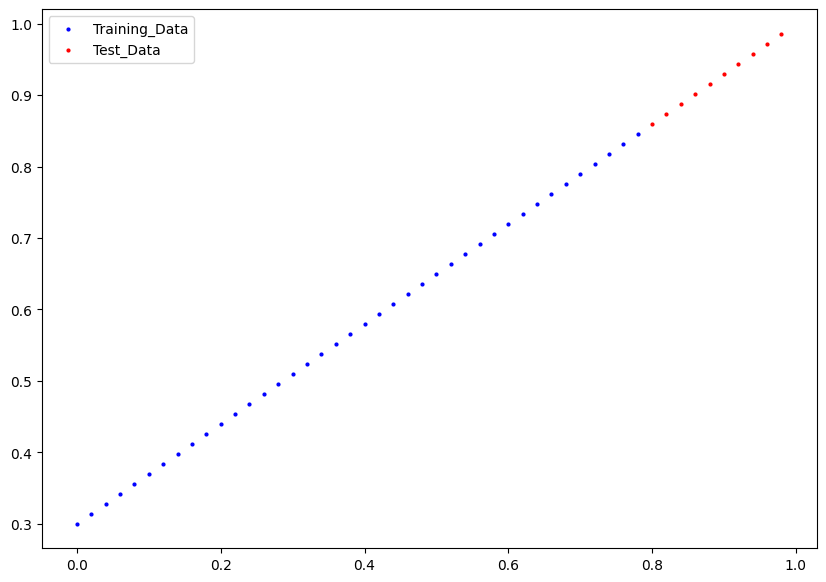

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c='b', s=4, label = 'Training_Data')
  plt.scatter(test_data, test_labels, c='r', s=4, label = 'Test_Data')

  if predictions is not None:
    plt.scatter(test_data, predictions, c='g', s=4, label = 'Predictions')

  plt.legend()


plot_predictions()

#### **Build Model**

In [ ]:
# Creating Linear Regression Model

class LinearRegression(nn.Module):

  def __init__(self):
    super().__init__()

    self.weight = nn.Parameter(torch.randn(1,                    # start with random weight
                                            dtype = torch.float,
                                            requires_grad = True)) # update this value with gradient descent
    self.bias = nn.Parameter(torch.randn(1,
                                         dtype = torch.float,
                                         requires_grad = True))


  # this defines the computation in the model
  def forward(self, x : torch.tensor) -> torch.tensor:
    return self.weight * x + self.bias

| PyTorch module        | What does it do? |
|----------------------|------------------|
| `torch.nn` | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| `torch.nn.Parameter` | Stores tensors that can be used with `nn.Module`. If `requires_grad=True`, gradients (used for updating model parameters via **gradient descent**) are calculated automatically. This is often referred to as **autograd**. |
| `torch.nn.Module` | The base class for all neural network modules. All building blocks for neural networks are subclasses of this. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method to be implemented. |
| `torch.optim` | Contains various optimization algorithms. These tell the model parameters stored in `nn.Parameter` how to change in order to improve gradient descent and reduce the loss. |
| `def forward()` | All `nn.Module` subclasses require a `forward()` method. This defines the computation that will take place on the data passed to the particular `nn.Module` (e.g., the linear regression formula). |


![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)

__checking the content of the model__

In [ ]:
torch.manual_seed(42)

model0 = LinearRegression()

list(model0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
  model0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# making predictions with random intialized model [inference_mode turns off things like gradient tracking etc.]

with torch.inference_mode():
  y_preds = model0(X_test)

In [ ]:
len(X_test), len(y_preds), len(y_test)

(10, 10, 10)

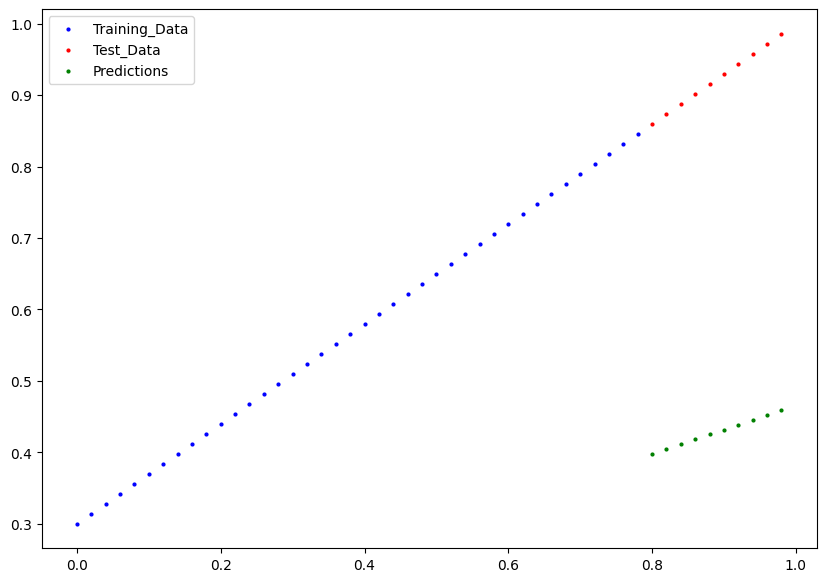

In [ ]:
plot_predictions(predictions=y_preds)

Above predictions are bad, it's just becuase we took the random intialized model and predicted on that.

#### **Training Model**

Model to update its parameters on its own, we'll need to add a few more things,
and that's a loss function as well as an optimizer.


**Loss Functions**

| Item | Description |
|-----|-------------|
| Purpose | Measures prediction error of the model, Lower the better |
| Location | `torch.nn` |
| Examples | `torch.nn.L1Loss()` --> MAE, `torch.nn.BCELoss()` --> Binary Classification|

**Optimizers**

| Item | Description |
|-----|-------------|
| Purpose | Tells model how to update parameters to lower the loss|
| Location | `torch.optim` |
| Examples | `torch.optim.SGD()`, `torch.optim.Adam()` |


Mean absolute error (MAE, in PyTorch: torch.nn.L1Loss) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.



In [ ]:
sum(y_test - y_preds) / len(y_test), np.mean((y_test - y_preds).numpy()) # this is MAE

(tensor([0.4945]), np.float32(0.49453616))

In [ ]:
loss_fn = nn.L1Loss() # MAE


'''
params -> is the target model parameters you'd like to optimize (e.g. the weights and bias values we randomly set before).
lr -> (learning rate) is the hyperparameter you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates
(these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer
will take too long to find the ideal values).
'''

optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr = 0.01)

[Learning Rate scheduler](https://docs.pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

In [ ]:
optimizer, loss_fn

(SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ),
 L1Loss())

__Training & Testing Loop__

The training loop involves the model going through the training data and learning the relationships between the features and labels.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training).

Training loop

| # | Step name | What does it do? | Code example |
|---|----------|------------------|--------------|
| 1 | **Forward pass** | Model runs once over training data and performs its `forward()` computations. | `y_pred = model(x_train)` |
| 2 | **Calculate loss** | Compares predictions with ground truth labels to measure error. | `loss = loss_fn(y_pred, y_train)` |
| 3 | **Zero gradients** | Clears old gradients since they accumulate by default in PyTorch. | `optimizer.zero_grad()` |
| 4 | **Backpropagation** | Computes gradients of the loss w.r.t. all trainable parameters (`requires_grad=True`). | `loss.backward()` |
| 5 | **Optimizer step** | Updates model parameters using gradients (gradient descent). | `optimizer.step()` |

------

Testing loop

1. Forward pass for the test data
2. calculate the loss
3. Make predictions on the test data

In [ ]:
# trainig and testing model

torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

  # Training Model
  model0.train()  # putting the model in training mode
  y_pred = model0(X_train) # forward pass
  loss = loss_fn(y_pred, y_train) # calculating training loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing Model
  model0.eval()
  with torch.inference_mode():
    test_pred = model0(X_test)
    test_loss = loss_fn(test_pred, y_test.type(torch.float))


    # Prinint out training/testing status

    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f'Epoch:{epoch} | Train Loss:{loss} | Test Loss:{test_loss}')

Epoch:0 | Train Loss:0.008932482451200485 | Test Loss:0.005023092031478882
Epoch:10 | Train Loss:0.008932482451200485 | Test Loss:0.005023092031478882
Epoch:20 | Train Loss:0.008932482451200485 | Test Loss:0.005023092031478882
Epoch:30 | Train Loss:0.008932482451200485 | Test Loss:0.005023092031478882
Epoch:40 | Train Loss:0.008932482451200485 | Test Loss:0.005023092031478882
Epoch:50 | Train Loss:0.008932482451200485 | Test Loss:0.005023092031478882
Epoch:60 | Train Loss:0.008932482451200485 | Test Loss:0.005023092031478882
Epoch:70 | Train Loss:0.008932482451200485 | Test Loss:0.005023092031478882
Epoch:80 | Train Loss:0.008932482451200485 | Test Loss:0.005023092031478882
Epoch:90 | Train Loss:0.008932482451200485 | Test Loss:0.005023092031478882


![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

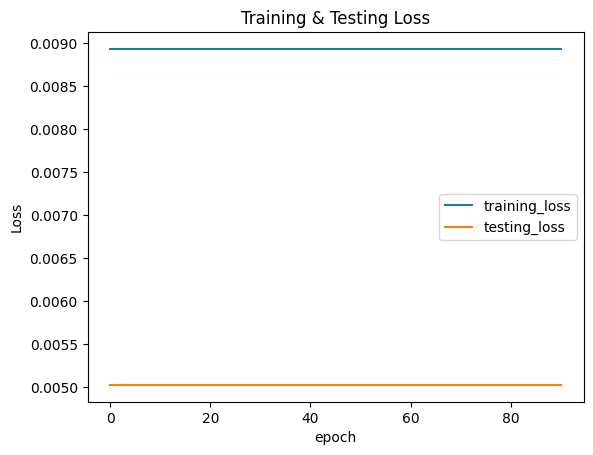

In [ ]:
plt.plot(epoch_count, train_loss_values, label = 'training_loss')
plt.plot(epoch_count, test_loss_values, label = 'testing_loss')
plt.title('Training & Testing Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

__Making Predictions__

In [ ]:
model0.eval()

with torch.inference_mode():
  y_preds = model0(X_test)

print(y_preds)

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])


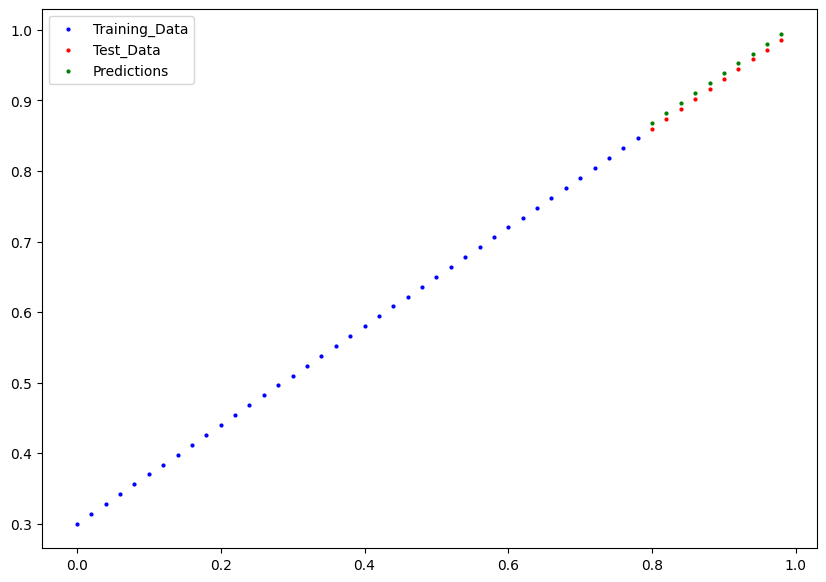

In [ ]:
plot_predictions(predictions=y_preds)

Woohoo! Those red dots are looking far closer than they were before!

#### **Saving and Loading PyTorch Model**

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

In [ ]:
from pathlib import Path

In [ ]:
MODEL_PATH = Path('models') # creating a models dir
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = '01_pytorch_linearregression.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model0.state_dict(),
           f = MODEL_SAVE_PATH)


Loading model and inferencing

In [59]:
load_model = LinearRegression()

In [61]:
load_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


load_model, load_model.state_dict()

(LinearRegression(),
 OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))]))

In [63]:
load_model.eval()

with torch.inference_mode():
  y_preds_load = load_model(X_test)



# Compare previous model predictions with loaded model predictions (these should be the same)

y_preds == y_preds_load

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])


1. `torch.save` 	Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.
2. `torch.load` 	Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).
3. `torch.nn.Module.load_state_dict` 	Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

-----

Blogs to refer :



1.   [Gradient Descent Unraveled](https://towardsdatascience.com/gradient-descent-unraveled-3274c895d12d-2/)
2.   [What is torch.nn really?](https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html)

